# 📋 ATML PA4 - Task 3: FedAvg on Non-IID Data

In this task, we will study the impact of statistical heterogeneity (non-IID data) on the performance of the standard **FedAvg** algorithm. We will use the `load_cifar10_noniid_dirichlet` function to create data partitions with varying levels of label skew, controlled by the Dirichlet distribution parameter **α** (alpha).

**Goal:** Compare FedAvg's convergence speed, final accuracy, and client drift across different levels of heterogeneity (from highly non-IID with `α=0.05` to nearly IID with `α=100`).

We will keep all other hyperparameters constant (`K=5`, `f=1.0`) to isolate the effect of the data distribution.

## **Part 1: Environment Setup**

### **1.1. Imports and Configuration**

First, we import all necessary libraries and our functions from `federated_learning.py`. We also define the main configuration parameters for the experiments.

In [1]:
# ============================================
# 📦 Imports and Environment Setup
# ============================================
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# --- Add path to federated_learning.py ---
# (Using the same path logic as task_4.1.py)
fed_avg_path = os.path.abspath(os.path.join(os.getcwd(), "../FedAvg"))

if fed_avg_path not in sys.path:
    print(f"Adding path: {fed_avg_path}")
    sys.path.append(fed_avg_path)
else:
    print(f"Path already in sys.path: {fed_avg_path}")
# -----------------------------------------

try:
    from federated_learning import (federated_train,
                                    load_cifar10_noniid_dirichlet)

    print("Successfully imported federated_learning module.")
except ImportError:
    print(f"Error: 'federated_learning.py' not found in path: {fed_avg_path}")
    print("Please ensure the path is correct and the file exists.")
    # sys.exit(1) # This might stop the notebook kernel

# ============================================
# ⚙️ Main Configuration
# ============================================
print("Configuring experiment...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Fixed Hyperparameters (as per roadmap) ---
NUM_CLIENTS = 10
NUM_ROUNDS = 50
LEARNING_RATE = 0.01
BATCH_SIZE = 32
SEED = 42
K_EPOCHS = 5  # Fixed local epochs
CLIENT_FRACTION = 1.0  # All clients participate

# ============================================
# ⚙️ Control Flag
# ============================================
FORCE_RETRAIN = False  # Set to True to re-run all training
print(f"FORCE_RETRAIN set to: {FORCE_RETRAIN}")

Adding path: /root/IbsATML/FedAvg
Successfully imported federated_learning module.
Configuring experiment...
Using device: cuda
FORCE_RETRAIN set to: False


### **1.2. Directory Setup**

We create the directories to store our JSON results, plots, and saved models for this task.

In [2]:
# ============================================
# 📂 Directory Setup
# ============================================
PLOT_DIR = 'plots'
JSON_DIR = 'json_results'
MODEL_DIR = 'pth_models'

os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(JSON_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Results will be saved in: {JSON_DIR}")
print(f"Plots will be saved in: {PLOT_DIR}")
print(f"Models will be saved in: {MODEL_DIR}")

Results will be saved in: json_results
Plots will be saved in: plots
Models will be saved in: pth_models


## **Part 2: Experiment Configuration**

### **2.1. Define Experiment Scenarios**

We define the list of Dirichlet `alpha` values to test. A small `alpha` (e.g., 0.05) means high heterogeneity, while a large `alpha` (e.g., 100) means the data is nearly IID.

In [3]:
# ============================================
# 🔬 Experiment Definitions
# ============================================

# Define the different heterogeneity levels (alpha values) to test
alpha_values = {
    'Highly_Non-IID': 0.05,
    'Non-IID': 0.2,
    'Moderately_Non-IID': 1.0,
    'Nearly_IID': 100.0,
}

# Store all results in this dictionary
all_results = {}

print("Defined experiment scenarios (by alpha):")
print(f"Alpha values: {list(alpha_values.values())}")

Defined experiment scenarios (by alpha):
Alpha values: [0.05, 0.2, 1.0, 100.0]


## **Part 3: Main Experiment Loop**

Now we run the experiments. We loop through each `alpha` value, load the corresponding non-IID data *once*, and then run FedAvg (`mu=0.0`) on that data split.

We use the `FORCE_RETRAIN` flag to skip training if a results file already exists.

In [4]:
# ============================================
# 🚀 Main Experiment Loop
# ============================================

json_name = f"results_heterogeneity.json"
json_path = os.path.join(JSON_DIR, json_name)

if os.path.exists(json_path) and not FORCE_RETRAIN:
    print(f"\n{'='*70}")
    print(f"📂 Loading existing results for: {json_name}")
    print(f"{'='*70}\n")

    with open(json_path, "r") as f:
        all_results = json.load(f)

    print(f"✅ Loaded {len(all_results)} experiment results from {json_path}")

else:
    # If we reach here, we need to train
    print(f"\n{'='*70}")
    print(f"🔥 Running experiments for Non-IID Heterogeneity")
    print(f"{'='*70}\n")
    
    # Loop through each alpha value and run training
    for exp_name, alpha in alpha_values.items():

        print(f"\n--- Running: {exp_name} (α={alpha}) ---")

        # 1. Create non-IID data ONCE for this alpha
        print(f"Loading non-IID data (alpha={alpha})...")
        train_loaders, test_loader, client_sizes = load_cifar10_noniid_dirichlet(
            num_clients=NUM_CLIENTS, 
            alpha=alpha, 
            batch_size=BATCH_SIZE, 
            seed=SEED
        )
        print("Data loaded.")

        # 2. Run FedAvg (mu=0)
        model, history = federated_train(
            num_clients=NUM_CLIENTS,
            num_rounds=NUM_ROUNDS,
            local_epochs=K_EPOCHS,
            client_fraction=CLIENT_FRACTION,
            lr=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            device=device,
            seed=SEED,
            mu=0.0,  # Pure FedAvg
            train_loaders=train_loaders,
            test_loader=test_loader,
            client_sizes=client_sizes,
        )

        all_results[exp_name] = history

        # 3. Save model checkpoint
        model_name = f"model_{exp_name}_alpha={alpha:.2f}.pth"
        model_path = os.path.join(MODEL_DIR, model_name)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model to {model_path}")

    # 4. Save results JSON after all alphas are complete
    with open(json_path, "w") as f:
        json.dump(all_results, f, indent=4)
    print(f"\n💾 Saved all heterogeneity results to {json_path}")


print("\n" + "=" * 70)
print("✅ All experiments complete.")
print("=" * 70)


📂 Loading existing results for: results_heterogeneity.json

✅ Loaded 4 experiment results from json_results/results_heterogeneity.json

✅ All experiments complete.


## **Part 4: Plotting and Analysis**

### **4.1. Generate Comparison Plots**

We now plot the results. We create a side-by-side comparison of **Test Accuracy** and **Client Drift** for all `alpha` values. We expect to see that lower `alpha` (more heterogeneity) leads to lower final accuracy and higher client drift.

Generating comparison plots...
Saved plot to plots/plot_heterogeneity_comparison.png


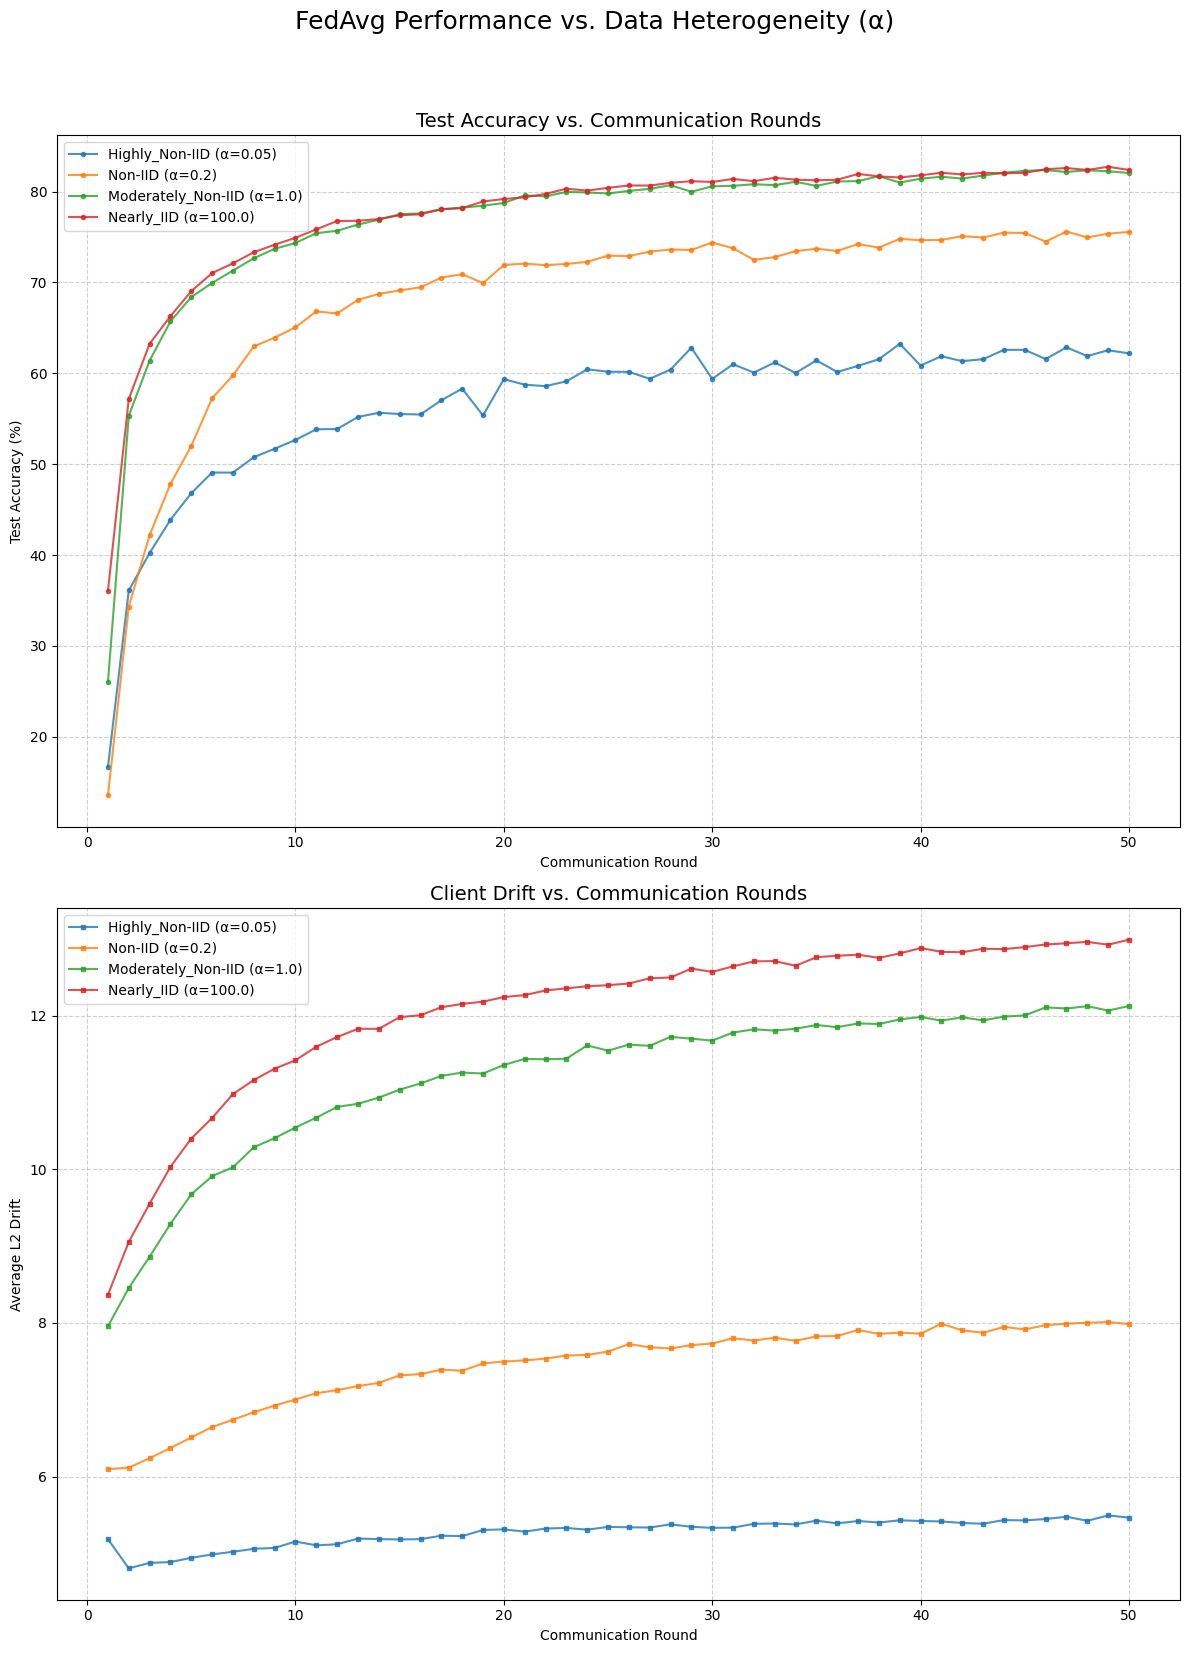

In [5]:
# ============================================
# 📊 Plotting Results
# ============================================
print("Generating comparison plots...")

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
fig.suptitle(f'FedAvg Performance vs. Data Heterogeneity (α)', fontsize=18, y=1.03)

# --- Plot 1: Test Accuracy ---
axes[0].set_title('Test Accuracy vs. Communication Rounds', fontsize=14)
axes[0].set_xlabel('Communication Round')
axes[0].set_ylabel('Test Accuracy (%)')

for exp_name, history in all_results.items():
    alpha = alpha_values[exp_name]
    label = f"{exp_name} (α={alpha})"
    axes[0].plot(history['rounds'], history['test_acc'], 
                 label=label, marker='o', markersize=3, alpha=0.8)

axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Client Drift ---
axes[1].set_title('Client Drift vs. Communication Rounds', fontsize=14)
axes[1].set_xlabel('Communication Round')
axes[1].set_ylabel('Average L2 Drift')

for exp_name, history in all_results.items():
    alpha = alpha_values[exp_name]
    label = f"{exp_name} (α={alpha})"
    axes[1].plot(history['rounds'], history['client_drift'], 
                 label=label, marker='s', markersize=3, alpha=0.8)

axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# --- Save and Show Plot ---
plt.tight_layout()
plot_name = f'plot_heterogeneity_comparison.png'
plot_path = os.path.join(PLOT_DIR, plot_name)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to {plot_path}")
plt.show()

### **4.2. Create Summary Table**

Finally, we'll generate a summary table using `pandas` to show the key final metrics. This helps in quickly comparing the performance for the report.

In [6]:
# ============================================
# 📈 Analysis & Summary Table
# ============================================
print("\n" + "="*70)
print("📊 Summary Table")
print("="*70)

summary_data = []

for exp_name, history in all_results.items():
    summary_data.append({
        'Scenario': exp_name,
        'α': alpha_values[exp_name],
        'Final Accuracy (%)': history['test_acc'][-1],
        'Final Drift': history['client_drift'][-1],
        'Avg Accuracy (last 10 rounds)': np.mean(history['test_acc'][-10:]),
        'Std Dev (last 10 rounds)': np.std(history['test_acc'][-10:])
    })

summary_df = pd.DataFrame(summary_data)

# Display the table in markdown format, sorted by alpha
print(summary_df.sort_values(by='α').to_markdown(index=False, floatfmt=".3f"))

print("\n--- Analysis complete. ---")


📊 Summary Table
| Scenario           |       α |   Final Accuracy (%) |   Final Drift |   Avg Accuracy (last 10 rounds) |   Std Dev (last 10 rounds) |
|:-------------------|--------:|---------------------:|--------------:|--------------------------------:|---------------------------:|
| Highly_Non-IID     |   0.050 |               62.200 |         5.465 |                          62.102 |                      0.499 |
| Non-IID            |   0.200 |               75.560 |         7.985 |                          75.169 |                      0.367 |
| Moderately_Non-IID |   1.000 |               82.050 |        12.126 |                          82.042 |                      0.304 |
| Nearly_IID         | 100.000 |               82.390 |        12.989 |                          82.272 |                      0.269 |

--- Analysis complete. ---
